# 6. Water resources data science

In this module, we will walk through an example data science project, starting from scratch. We will make use of the resources that we have gained familariarty with in the past modules, and introduce some new concepts. 

We need some practical knowledge about **Application Programming Interfaces, or APIs**. 

## APIs

APIs allow you to quickly retrieve custom data - e.g. for a specific area, or timeframe. 

An API is like a waiter at a restaurant: it's a set of rules that allows different software programs to communicate and exchange information with each other, just like a waiter takes your order and delivers it to the kitchen, bringing back your food when it's ready; you don't need to know how the kitchen works, just what to order and how to ask for it - that's the "interface" provided by the waiter.

In this module we will use the [OpenET API](https://openet.gitbook.io/docs/reference/api-reference) to acquire evapotranspiration data. To access this excellent resource, you need to sign up for the OpenET service, and obtain an "API key" or "token", [which can be done here](https://account.etdata.org/settings/api), though example data will be provided as `.csv` alongside this tutorial. 

### APIs vs Snowflake

APIs and Snowflake are similar in that they are ways to store and exchange information. 

## Organizing a data science project

Like in life, organization in software, data science, and general computing is critically important. Organizing a project well from the outset is likely to save time in the later stages, and as collaborators are added and/or ownership changes. 

We will try as hard as we can to avoid the most common pitfall described in the below XKCD comic:

![data_flows](./img/6-data-pipeline.png)

Here is an example of how one might organize a data science project:

```
project_name
│   README.md
│   api_key.txt    
│
└───code/
│   │   00_get_data.py
│   │   01_process_data.py
│   │   02_analyze_data.py
│   │   03_plot_results.py
│   │   ...        
│   │
│   └───submodule/
│       │   file111.txt
│       │   file112.txt
│       │   ...
│   
└───data/
│   │
│   └───Source1/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│       │
│   └───Source2/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│
└───GIS/
│   │
│   └───Source1/
│       │   file1.geojson
│       │   file2.kml
│       │   ...
│       │
│   └───Source2/
│       │   file1.shp
│       │   file2.xlsx
│       │   ...
│   
└───results
│   │
│   └───Analysis1/
│       │   file1.csv
│       │   file2.txt
│       │   ...
│       │
│   └───Analysis2/
│       │   file1.csv
│       │   file2.txt
│       │   ...
```

Lets spend a few minutes discussing the above - what are some alternate naming conventions you might adopt? What are some additional folders that might be added? 

## Water Resources Data Science Project - ET and GWL

Let's say we are interested in analyzing the dynamical interplay between groundwater levels and evapotranspiration. Let's develop a python workflow to do the following:

1. Read `.csv` data describing groundwater station locations (`stations.csv`)
2. Select a number of stations from the larger dataset based on a list of `station_ids`
3. Join the station data to groundwater level data based on a column value 
4. Use the location information contained in the `stations.csv` to determine the lat/lon of each station
5. For each groundwater monitoring location:
   * Determine lat/lon coordinates
   * Query the collocated ET data 
   * Organize ET and GWL time series data as dataframes
   * Ensure that time windows of data overlap
   * Write files to directory
6. Analyze the correlation and lag between peak ET and peak GWL
7. Plot and write our results to file

### Data Loading, Preparation, and EDA

Lets say we want to perform our analysis for the following site IDs:
```
['382913N1213131W001',
 '384082N1213845W001',
 '385567N1214751W001',
 '386016N1213761W001',
 '387511N1213389W001',
 '388974N1213665W001',
 '383264N1213191W001',
 '382548N1212908W001',
 '388943N1214335W001',
 '384121N1212102W001']
```

We can use `pandas` to read and inspect the data, filter for the appropriate `SITE_CODE` rows given by the IDs above, and finally join the `stations` and `measurements` data. 

In [1]:
import pandas as pd

# Read the GWL data csv files into pandas dataframes
df_stns = pd.read_csv("./data/gwl/stations.csv")
df_gwl_all = pd.read_csv("./data/gwl/measurements_sep.csv")

In [2]:
# Inspect the columns of the data
df_gwl_all.head()

,STN_ID,SITE_CODE,WLM_ID,MSMT_DATE,WLM_RPE,WLM_GSE,RDNG_WS,RDNG_RP,WSE,RPE_WSE,GSE_WSE,WLM_QA_DESC,WLM_DESC,WLM_ACC_DESC,WLM_ORG_ID,WLM_ORG_NAME,MSMT_CMT,COOP_AGENCY_ORG_ID,COOP_ORG_NAME
0,4775,384931N1212618W001,1443624,2004-03-01T00:00:00Z,118.4,117.4,0.0,127.0,-8.6,127.0,126.0,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
1,4775,384931N1212618W001,1443625,2003-10-01T00:00:00Z,118.4,117.4,0.0,121.7,-3.3,121.7,120.7,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
2,4775,384931N1212618W001,1443622,2003-03-15T00:00:00Z,118.4,117.4,0.0,119.5,-1.1,119.5,118.5,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
3,4775,384931N1212618W001,1443620,2002-10-01T00:00:00Z,118.4,117.4,0.0,128.9,-10.5,128.9,127.9,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT
4,4775,384931N1212618W001,1443621,2001-10-01T00:00:00Z,118.4,117.4,0.0,131.4,-13.0,131.4,130.4,NaN,Unknown,Water level accuracy is unknown,1,Department of Water Resources,NaN,1074,SACRAMENTO MUNICIPAL UTILITY DISTRICT


In [3]:
# Inspect the data types
df_gwl_all.dtypes

STN_ID                  int64
SITE_CODE              object
WLM_ID                  int64
MSMT_DATE              object
WLM_RPE               float64
WLM_GSE               float64
RDNG_WS               float64
RDNG_RP               float64
WSE                   float64
RPE_WSE               float64
GSE_WSE               float64
WLM_QA_DESC            object
WLM_DESC               object
WLM_ACC_DESC           object
WLM_ORG_ID              int64
WLM_ORG_NAME           object
MSMT_CMT               object
COOP_AGENCY_ORG_ID      int64
COOP_ORG_NAME          object
dtype: object

In [4]:
# Inspect the columns of the data
df_stns.head()

,STN_ID,SITE_CODE,SWN,WELL_NAME,LATITUDE,LONGITUDE,WLM_METHOD,WLM_ACC,BASIN_CODE,BASIN_NAME,COUNTY_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,ZIP_CODE
0,51445,320000N1140000W001,NaN,Bay Ridge,35.5604,-121.755,USGS quad,Unknown,NaN,NaN,Monterey,NaN,Residential,Part of a nested/multi-completion well,NaN,92154
1,25067,325450N1171061W001,19S02W05K003S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
2,25068,325450N1171061W002,19S02W05K004S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
3,39833,325450N1171061W003,19S02W05K005S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154
4,25069,325450N1171061W004,19S02W05K006S,NaN,32.5450,-117.106,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,NaN,92154


In [5]:
# Inspect the data types
df_stns.dtypes

STN_ID           int64
SITE_CODE       object
SWN             object
WELL_NAME       object
LATITUDE       float64
LONGITUDE      float64
WLM_METHOD      object
WLM_ACC         object
BASIN_CODE      object
BASIN_NAME      object
COUNTY_NAME     object
WELL_DEPTH     float64
WELL_USE        object
WELL_TYPE       object
WCR_NO          object
ZIP_CODE         int64
dtype: object

In [6]:
# Define our site ids:
site_ids = [
    "382913N1213131W001",
    "384082N1213845W001",
    "385567N1214751W001",
    "386016N1213761W001",
    "387511N1213389W001",
    "388974N1213665W001",
    "383264N1213191W001",
    "382548N1212908W001",
    "388943N1214335W001",
    "384121N1212102W001",
]

df_gwl = df_gwl_all[df_gwl_all["SITE_CODE"].isin(site_ids)]
df_gwl.head()

,STN_ID,SITE_CODE,WLM_ID,MSMT_DATE,WLM_RPE,WLM_GSE,RDNG_WS,RDNG_RP,WSE,RPE_WSE,GSE_WSE,WLM_QA_DESC,WLM_DESC,WLM_ACC_DESC,WLM_ORG_ID,WLM_ORG_NAME,MSMT_CMT,COOP_AGENCY_ORG_ID,COOP_ORG_NAME
1422,4824,382913N1213131W001,2662873,2020-09-17T00:00:00Z,44.8,43.5,4.0,95.0,-46.2,91.0,89.7,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1423,4824,382913N1213131W001,2662004,2020-08-28T00:00:00Z,44.8,43.5,4.9,9.5,40.2,4.6,3.3,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1424,4824,382913N1213131W001,2657077,2020-07-23T00:00:00Z,44.8,43.5,5.0,95.0,-45.2,90.0,88.7,NaN,Steel tape measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1425,4824,382913N1213131W001,2630628,2020-06-25T00:00:00Z,44.8,43.5,1.2,90.0,-44.0,88.8,87.5,NaN,Electric sounder measurement,Water level accuracy to nearest tenth of a foot,1,Department of Water Resources,Run 18,1,Department of Water Resources
1426,4824,382913N1213131W001,2624819,2020-05-22T00:00:00Z,44.8,43.5,3.3,90.0,-41.9,86.7,85.4,NaN,Steel tape measurement,Water level accuracy to nearest foot,1,Department of Water Resources,Run 18,1,Department of Water Resources


In [7]:
# It looks like there could be some duplicates in the GWL data
# we can use the 'drop duplicates' function to eliminate them
df_gwl = df_gwl.drop_duplicates()

In [8]:
# Set the 'MSMT_DATE' column to a pandas datetime object
# Note that the data type is object - we must first conver to string
datetime_strings = df_gwl.loc[:, "MSMT_DATE"].astype(str)
df_gwl.loc[:, "Datetime"] = pd.to_datetime(datetime_strings)

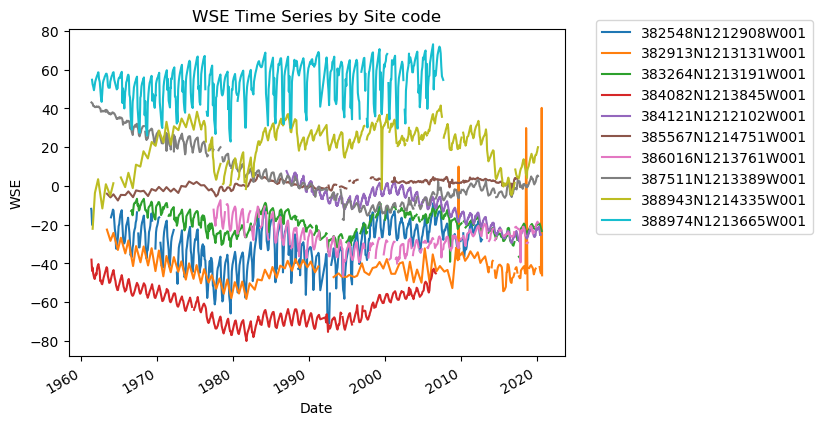

In [9]:
# Sanity check - Plot GWLs for each SITE CODE
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for category, group in df_gwl.groupby("SITE_CODE"):
    group.plot(x="Datetime", y="WSE", ax=ax, label=category)

plt.title("WSE Time Series by Site code")
plt.xlabel("Date")
plt.ylabel("WSE")
plt.legend(bbox_to_anchor=(1.05, 1.05))  # move the legend outside the plot
plt.show()

I notice a few things here: 
* There are gaps in data
* There are potentially anomalous values in some of the datasets
* It might be nice to standardize the data to compare, i.e. make all observations start at zero. 

How can we go about fixing these? 
* Gaps - interpolation
* Anomalous values - smoothing
* Standardization - difference time series from first value

Let's go about making these modifications.

Anything else you notice about the data? 

### Preprocessing and Filtering

#### Interpolation

We can interpolate missing values using the handy `pandas` function `df.interpolate`, and specify the interpolation method using the `how` argument. 

Let's do this for each site code. In order to accomplish this, we will first create an empty list to store our results, then loop through each unique site code, perform the interpolation, and update the list with the interpolated result. Then, we'll concatenate the results and plot to sanity check. 

In [10]:
interp_results = []

for site in df_gwl["SITE_CODE"].unique():
    site_df = df_gwl[df_gwl["SITE_CODE"] == site].sort_values("Datetime")
    # interp_wse = site_df.loc[:,'WSE'].interpolate(how = 'polynomial',order = 3)
    interp_wse = site_df.loc[:, "WSE"].interpolate(how="linear").values
    site_df.loc[:, "WSE_interp"] = interp_wse
    interp_results.append(site_df)

df_gwl_interp = pd.concat(interp_results)

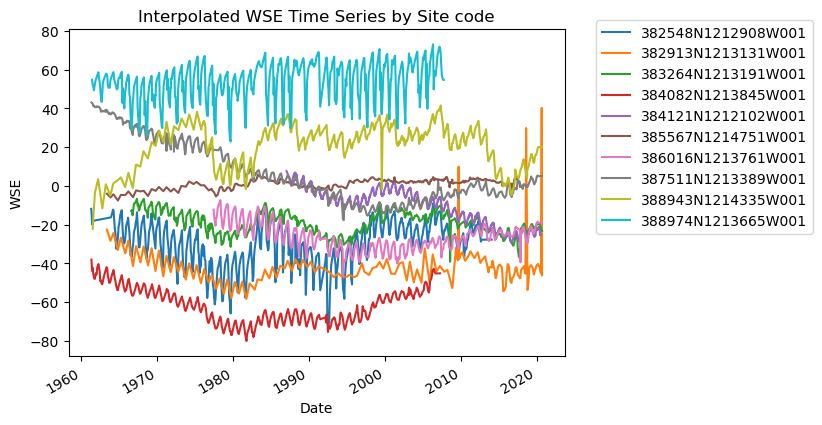

In [11]:
# Sanity check - Plot interpolated GWLs for each SITE CODE

fig, ax = plt.subplots()

for category, group in df_gwl_interp.groupby("SITE_CODE"):
    group.plot(x="Datetime", y="WSE_interp", ax=ax, label=category)

ax.set_title("Interpolated WSE Time Series by Site code")
ax.set_xlabel("Date")
ax.set_ylabel("WSE")
ax.legend(bbox_to_anchor=(1.05, 1.05))  # move the legend outside the plot

#### Smoothing 

We can smooth our `WSE` data by taking the rolling average over a given number of rows using the handy `pandas` function `df.rolling`, and specifying the aggregation method using the `.mean()` function. 

Let's do this for each site code. In order to accomplish this, we will first create an empty list to store our results, then loop through each unique site code, perform the interpolation, and update the list with the interpolated result. Then, we'll concatenate our results and plot them to sanity check. 

In [12]:
smooth_results = []

for site in df_gwl_interp["SITE_CODE"].unique():
    site_df = df_gwl_interp[df_gwl_interp["SITE_CODE"] == site].sort_values("Datetime")
    interp_wse_smooth = site_df.loc[:, "WSE_interp"].rolling(5).median()  # we smooth over 5 time periods
    site_df.loc[:, "WSE_interp_smooth"] = interp_wse_smooth
    smooth_results.append(site_df)

df_gwl_smooth = pd.concat(smooth_results)

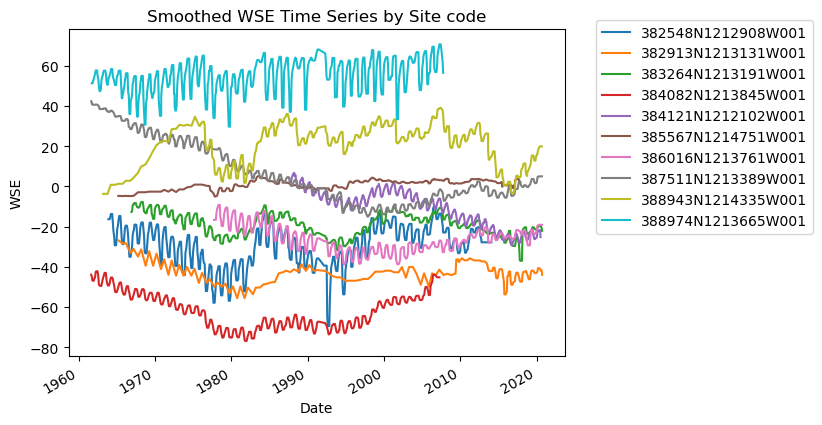

In [13]:
# Sanity check - Plot rolling median GWLs for each SITE CODE

fig, ax = plt.subplots()

for category, group in df_gwl_smooth.groupby("SITE_CODE"):
    group.plot(x="Datetime", y="WSE_interp_smooth", ax=ax, label=category)

ax.set_title("Smoothed WSE Time Series by Site code")
ax.set_xlabel("Date")
ax.set_ylabel("WSE")
ax.legend(bbox_to_anchor=(1.05, 1.05))  # move the legend outside the plot

#### Standardize data to begin at zero

We can subtract the first value from the rest of the time series to better facilitate comparison:

In [14]:
df_gwl_smooth.sort_values("Datetime", inplace=True)

standardized_results = []

for site in df_gwl_smooth["SITE_CODE"].unique():
    site_df = df_gwl_smooth[df_gwl_smooth["SITE_CODE"] == site].sort_values("Datetime")
    wse_standard = site_df["WSE_interp_smooth"].dropna() - site_df["WSE_interp_smooth"].dropna().values[0]
    site_df.loc[:, "wse_standard"] = wse_standard
    standardized_results.append(site_df)

df_gwl_standard = pd.concat(standardized_results)

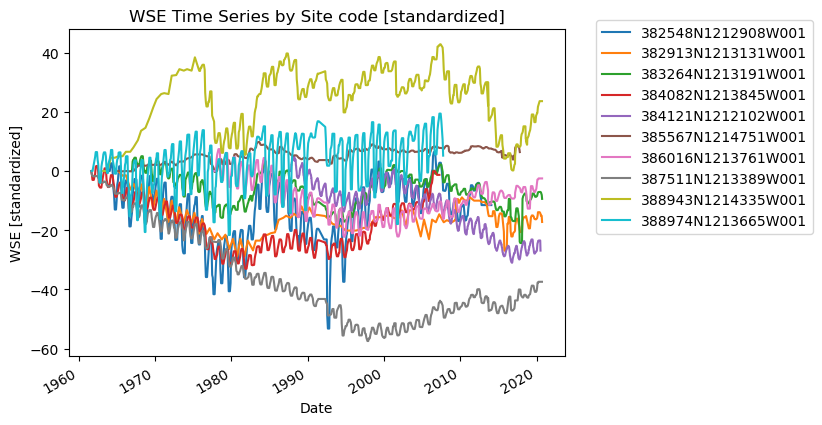

In [15]:
fig, ax = plt.subplots()

for category, group in df_gwl_standard.groupby("SITE_CODE"):
    group.set_index("Datetime")["wse_standard"].plot(ax=ax, label=category)


ax.set_title("WSE Time Series by Site code [standardized]")
ax.set_xlabel("Date")
ax.set_ylabel("WSE [standardized]")
plt.legend(bbox_to_anchor=(1.05, 1.05))  # move the legend outside the plot

In [16]:
# Let's go ahead and set the index to be the datetime for the whole dataframe:
# This helps us stay organized, and is useful later on for making pretty plots!

df_gwl_standard.set_index("Datetime", inplace=True)

### Data Processing and Synthesis

We have loaded, filtered, interpolated, smoothed, standardized, and plotted the groundwater level data. 

Let's next join these data to station locations (contained in `/data/stations.csv`), so we can use the geographic information to query an API to retrieve our supplementary ET data. 

#### Joining with station data

In [17]:
# A simple inner join.
df_joined = pd.merge(df_gwl_standard, df_stns, on="SITE_CODE", how="left")

In [18]:
# Verify we have joined the additional columns
[x for x in df_joined.columns if x not in df_gwl.columns and x not in df_gwl_standard.columns]

['STN_ID_x',
 'STN_ID_y',
 'SWN',
 'WELL_NAME',
 'LATITUDE',
 'LONGITUDE',
 'WLM_METHOD',
 'WLM_ACC',
 'BASIN_CODE',
 'BASIN_NAME',
 'COUNTY_NAME',
 'WELL_DEPTH',
 'WELL_USE',
 'WELL_TYPE',
 'WCR_NO',
 'ZIP_CODE']

### Open ET

[OpenET](https://etdata.org/) is a system that uses satellite data to calculate evapotranspiration (ET), essentially measuring the amount of water evaporating from the ground and transpiring from plants.

OpenET leverages [Google Earth Engine](https://earthengine.google.com/) as its primary platform for data processing and analysis, allowing for large-scale calculations and easy access to the generated data through a user-friendly graphical interface as well as programmatic API. 

#### Google Earth Engine

More broadly, Earth Enging is an API for [satellite and climate datasets](https://developers.google.com/earth-engine/datasets). There are thousands of available datasets on earth engine that can be accessed with a few lines of python code, and vibrant developer community who have authored many tutorials and examples. While an introduction to Earth Engine is beyond the scope of this course, Open ET is a nealy perfect motivating example for the utility of such a platform. |

#### Query the OpenET API from the lat / lon coordinates of each station

Let's use the latitude / longitude coordinates from each station to query the OpenET API and retreive ET data. 

In the below code, we will query the [OpenET API](https://openet.gitbook.io/docs/reference/api-reference) to retrieve ET data. The provided link contains the information on how to request data from the OpenET API. This request uses a private token in a file to authenticate the API request. An API key can be obtained [here](https://account.etdata.org/settings/api)

We use the module `requests` to accomplish this. 

In [19]:
# Import required modules
import os
import requests

In [20]:
# a quick demonstration of requests module
# Let's grab the headers (links) and texts from http://example.com
# Feel free to navigate there in a browser to see the web page
r = requests.get("https://example.com")
print("WEBSITE HEADERS:")
print(r.headers)
print("WEBSITE TEXT:")
print(r.text)

WEBSITE HEADERS:
{'Accept-Ranges': 'bytes', 'Content-Type': 'text/html', 'ETag': '"84238dfc8092e5d9c0dac8ef93371a07:1736799080.121134"', 'Last-Modified': 'Mon, 13 Jan 2025 20:11:20 GMT', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Content-Length': '648', 'Cache-Control': 'max-age=2881', 'Date': 'Fri, 14 Feb 2025 01:17:27 GMT', 'Alt-Svc': 'h3=":443"; ma=93600,h3-29=":443"; ma=93600,h3-Q050=":443"; ma=93600,quic=":443"; ma=93600; v="46,43"', 'Connection': 'keep-alive'}
WEBSITE TEXT:
<!doctype html>
<html>
<head>
    <title>Example Domain</title>

    <meta charset="utf-8" />
    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <style type="text/css">
    body {
        background-color: #f0f0f2;
        margin: 0;
        padding: 0;
        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;
      

In [21]:
# Now we will build on this to retrieve ET data from OpenET's API.


def fetch_et_point(point):
    """
    This function accepts a list of two floats denoting the point's longitude,latitude format
    Example Usage:
    >>> fetch_et([-121.890029, 37.088582])
    """
    # Read in our private API key
    with open("/Users/aakashahamed/Desktop/junkyard/openet_api.txt") as f:
        api_key = f.read()

    # Create a dictionary with our API
    header = {"Authorization": api_key}

    # endpoint arguments
    args = {
        "date_range": ["2015-01-01", "2023-12-31"],
        "geometry": point,
        "interval": "monthly",
        "model": "Ensemble",
        "variable": "ET",
        "reference_et": "gridMET",
        "units": "mm",
        "file_format": "JSON",
    }

    # query the api
    resp = requests.post(headers=header, json=args, url="https://openet-api.org/raster/timeseries/point")

    # build the out dataframe
    date_times = []
    et = []

    for i in resp.json():
        date_times.append(i["time"])
        et.append(i["et"])

    et_df = pd.DataFrame(et)
    et_df.columns = ["et_mm"]
    et_df["date"] = date_times
    et_df.set_index("date", inplace=True)

    return et_df

In [22]:
# Isolate the site codes, lat/lon coordinates by subsetting and dropping duplicate entries
et_site_df = df_joined[["LONGITUDE", "LATITUDE", "SITE_CODE"]].drop_duplicates()
et_site_df.head()

,LONGITUDE,LATITUDE,SITE_CODE
0,-121.291,38.2548,382548N1212908W001
595,-121.339,38.7511,387511N1213389W001
1328,-121.385,38.4082,384082N1213845W001
1869,-121.367,38.8974,388974N1213665W001
2440,-121.434,38.8943,388943N1214335W001


In [23]:
# Setup our dictionary to store results
results_dict = {}

# Loop through our dataframe, retrieve the ET data based on each lat / lon coordinate
for idx, row in et_site_df.iterrows():
    lat, lon = row["LATITUDE"], row["LONGITUDE"]
    site_code = row["SITE_CODE"]
    print(f"processing {site_code} ========== ")

    # Check if we already have this file
    if not os.path.exists("./data/stn_et_mm.csv"):
        et_data = fetch_et_point([lon, lat])

    # Only if not, query the ET data via API
    else:
        et_data = pd.DataFrame(pd.read_csv("./data/stn_et_mm.csv").set_index("date")[site_code])

    results_dict[site_code] = et_data

processing 382548N1212908W001 ========== 
processing 387511N1213389W001 ========== 
processing 384082N1213845W001 ========== 
processing 388974N1213665W001 ========== 
processing 388943N1214335W001 ========== 
processing 385567N1214751W001 ========== 
processing 382913N1213131W001 ========== 
processing 383264N1213191W001 ========== 
processing 386016N1213761W001 ========== 
processing 384121N1212102W001 ========== 


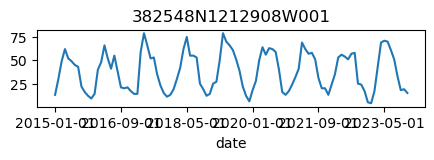

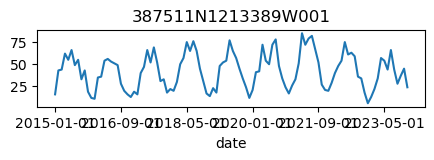

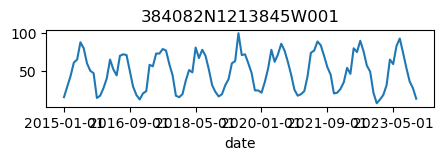

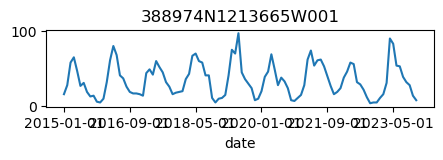

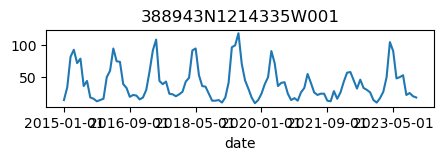

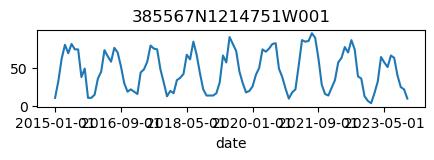

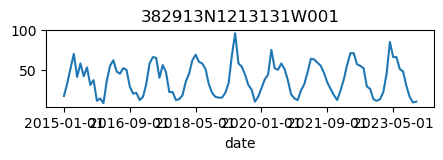

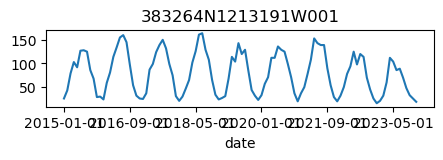

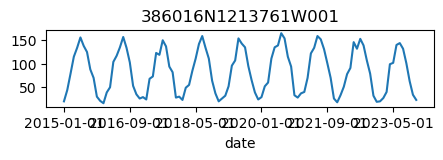

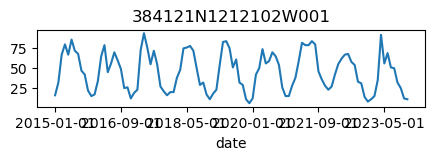

In [24]:
# Let's verify that the data was retrieved correctly and looks reasonable
for k, v in results_dict.items():
    ax = v.plot(figsize=(5, 1), legend=False)
    ax.set_title(k);

In [25]:
# Let's make a dataframe out of the dictionary we made

et_df_all = []

for (
    k,
    v,
) in results_dict.items():
    vdf = v.copy()
    vdf.columns = [k]
    et_df_all.append(vdf)

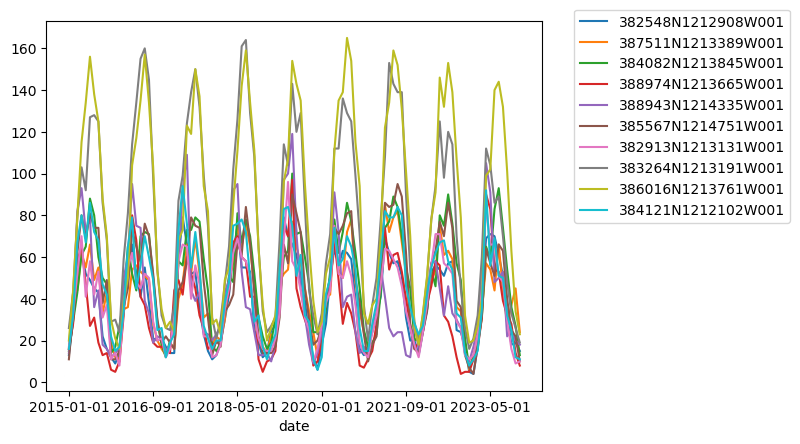

In [26]:
# And as always, plot the results to sanity check:

ax = pd.concat(et_df_all, axis=1).plot()
ax.legend(bbox_to_anchor=(1.05, 1.05))  # move the legend outside the plot

In [27]:
# Write to csv
import os

et_results_df = pd.concat(et_df_all, axis=1)

if not os.path.exists("./data/stn_et_mm.csv"):
    et_results_df.to_csv("./data/stn_et_mm.csv")

In [28]:
# Now, for each site, let's isolate the ET and GWLs to determine (1) correlation and (2) lag

site_id_list = list(results_dict.keys())

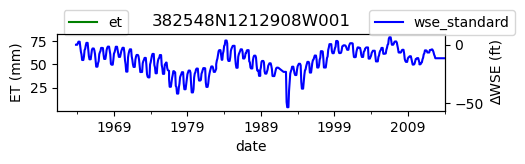

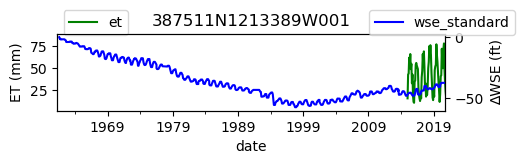

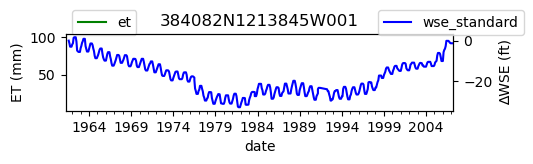

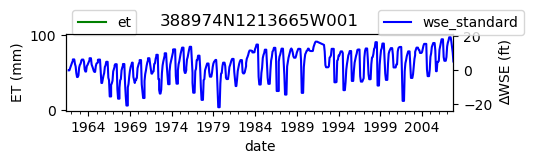

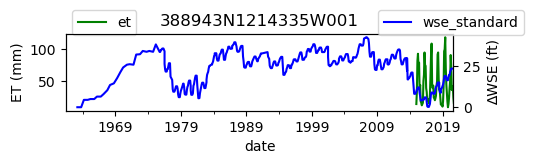

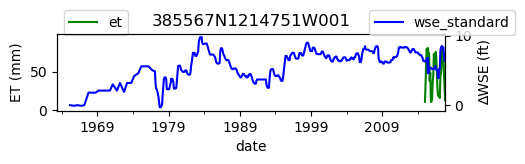

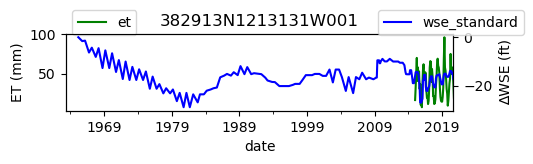

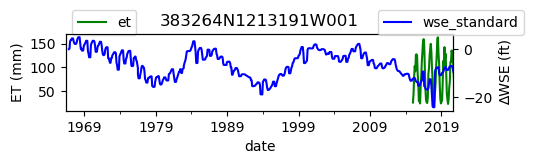

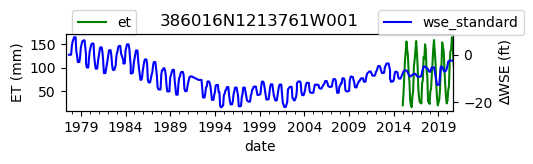

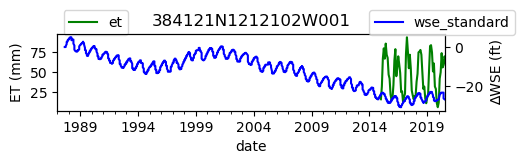

In [29]:
for site_id in site_id_list:

    # Get the GWL data
    df_site_gwl = df_gwl_standard[df_gwl_standard["SITE_CODE"] == site_id][["wse_standard"]]

    # Get the ET data
    df_site_et = pd.DataFrame(et_results_df[site_id])
    df_site_et.columns = ["et"]
    df_site_et.index = pd.to_datetime(df_site_et.index)

    # Plot both on separate axes
    ax = df_site_et.plot(figsize=(5, 1), color="green")
    ax.set_ylabel("ET (mm)")
    ax.legend(bbox_to_anchor=(0.2, 1.4))

    # Create another x axis
    ax2 = ax.twinx()
    df_site_gwl.plot(ax=ax2, color="blue")
    ax2.set_ylabel("∆WSE (ft)")
    ax2.legend(bbox_to_anchor=(1.2, 1.4))

    ax.set_title(site_id)

We notice that the dates between the two datasets do not exactly match up. and the ET data are marked at the start of each month. We can change the index for the gwl data to align with our ET data start of month convention using builtin pandas functions `.to_period('M').start_time `, and then proceed with the aligned data.

In [30]:
# Set the time index to the start of the month
df_gwl_standard.index = df_gwl_standard.index.to_period("M").start_time

/var/folders/py/9t078qzs52x65tkpvg23_4mc0000gn/T/ipykernel_34444/397549279.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_gwl_standard.index = df_gwl_standard.index.to_period('M').start_time


Note that we have received a warning about changing the timezones that we can safely ignore for an analysis conducted at the monthly level. 

### Data analysis

Let's first try to calculate a simple regression between ET and groundwater levels for the comporaneous data points at each site:

#### Linear Regression


In [31]:
regression_results_list = []

# Loop through our sites 
for site_id in site_id_list:

    # Get the GWL data 
    df_site_gwl = df_gwl_standard[df_gwl_standard['SITE_CODE'] == site_id][['wse_standard']]
    
    # Get the ET data 
    df_site_et = pd.DataFrame(et_results_df[site_id])
    df_site_et.columns = ['et']
    df_site_et.index = pd.to_datetime(df_site_et.index)

    # Join the dataframes via the outer join to preserve the index, and drop areas with no data 
    df_site = pd.DataFrame(df_site_et.dropna()).join(df_site_gwl.dropna(), how='outer')
    df_site['site'] = site_id
    regression_results_list.append(df_site)

In [32]:
reg_plot_df = pd.concat(regression_results_list).dropna()


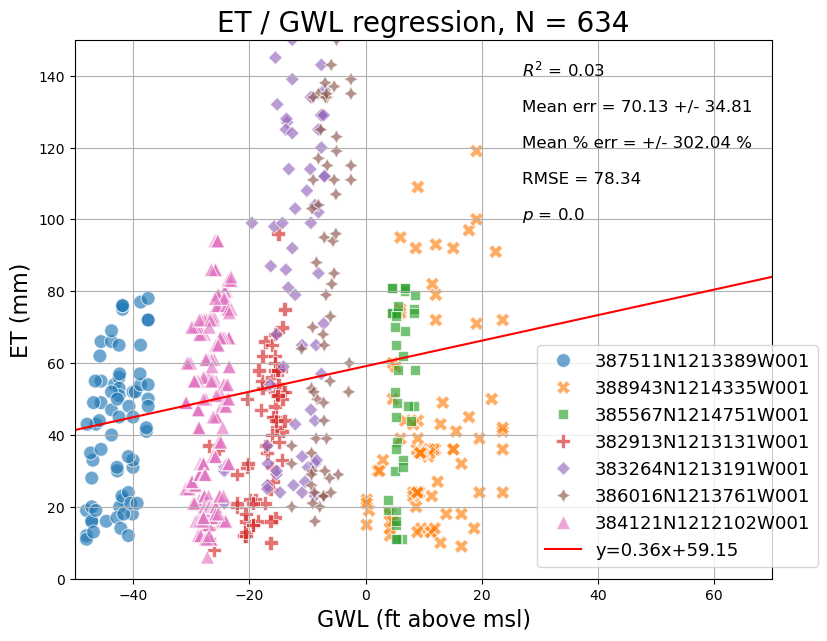

In [33]:
# Create and style a scatterplot with regression line, equation, R^2 value and other error statistics 
import numpy as np
import seaborn as sns
from scipy import stats

fig, ax = plt.subplots(figsize = (9,7))

sns.scatterplot(data = reg_plot_df, x = 'wse_standard', y = 'et', 
                hue = 'site', style = 'site', s = 100, alpha = 0.65, ax = ax)


# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(reg_plot_df['wse_standard'].astype(float), reg_plot_df['et'].astype(float))

# Mean absolute error
mae = np.nanmean((reg_plot_df['et'] - reg_plot_df['wse_standard']))
mae_std = np.nanstd(abs(reg_plot_df['et'] - reg_plot_df['wse_standard']))
mape = np.nanmean(((reg_plot_df['et'] - reg_plot_df['wse_standard']) / reg_plot_df['wse_standard'])) * 100
mape_std = np.nanstd(((reg_plot_df['et'] - reg_plot_df['wse_standard']) / reg_plot_df['wse_standard'])) * 100
rmse = ((reg_plot_df['et'] - reg_plot_df['wse_standard']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(-300,300)+ intercept
plt.plot(np.linspace(-300,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

# Annotations 
plt.annotate("$R^2$ = {}".format(str(round(r_value**2,2))), [27,140], size = 12)
plt.annotate("$p$ = {}".format(round(p_value,4)), [27,100], size = 12)
plt.annotate("Mean err = {} +/- {}".format(str(round(abs(mae),2)),str(round(mae_std,2))), [27,130], size = 12)
plt.annotate("Mean % err = +/- {} %".format(str(round(abs(mape),2)),str(round(mape_std,2))), [27,120], size = 12)
plt.annotate("RMSE = {}".format(str(round(rmse,2))), [27,110], size = 12)

# Add legend 
ax.legend(fontsize = 13, bbox_to_anchor=(0.65,0.45))

# Set axis limits
ax.set_xlim(-50,70)
ax.set_ylim(0,150)

# Add axis labels 
plt.xlabel("GWL (ft above msl)", size = 16)
plt.ylabel("ET (mm)", size = 16)

# Add title 
titlestr = "ET / GWL regression, N = {}".format(str(len(reg_plot_df)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

#### Cross Correlation

As suggested by the regression, there isn't much of a relationship betweeen ET and GWLs for a given contemporaneous month, but we note that these processes aren't necessarially in sync temporally.

Let's calculate the [correlation](https://en.wikipedia.org/wiki/Correlation), [cross correlation and cross correlation lag period](https://en.wikipedia.org/wiki/Cross-correlation) between monthly ET and monthly GWLs to account for the time lag between these processes

We first join the dataframes, and calculate the correlation using the `DataFrame.corr()` function from `pandas`. 

Next we calculate monthly means using `pandas` and `.groupby`. 

Lastly, we calculate the cross correlation using `numpy.correlate()` and lag period using `numpy.argmax`

-------------------------
382548N1212908W001
ET GWL CORRELATION = nan
ET GWL LAG = 1


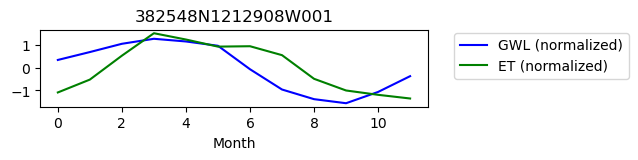

-------------------------
387511N1213389W001
ET GWL CORRELATION = 0.3585458273789301
ET GWL LAG = 1


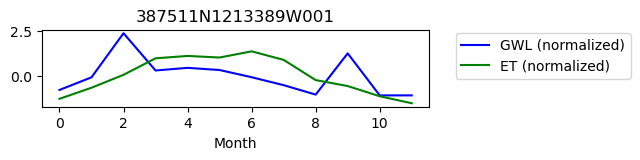

-------------------------
384082N1213845W001
ET GWL CORRELATION = nan
ET GWL LAG = 1


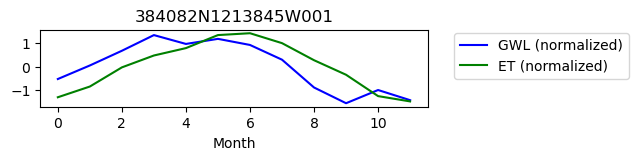

-------------------------
388974N1213665W001
ET GWL CORRELATION = nan
ET GWL LAG = 1


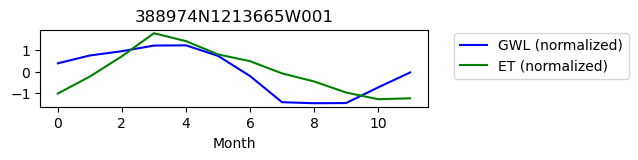

-------------------------
388943N1214335W001
ET GWL CORRELATION = 0.255705792529907
ET GWL LAG = 0


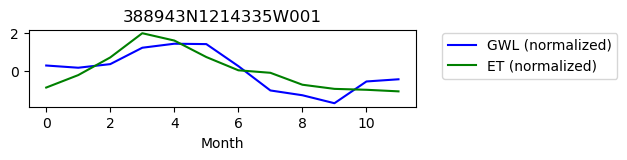

-------------------------
385567N1214751W001
ET GWL CORRELATION = 0.2675723544297554
ET GWL LAG = 0


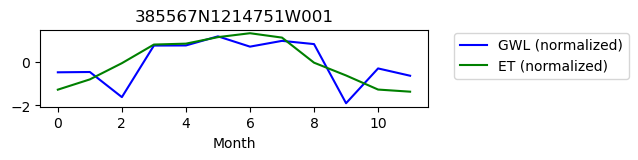

-------------------------
382913N1213131W001
ET GWL CORRELATION = 0.5808415058687348
ET GWL LAG = 0


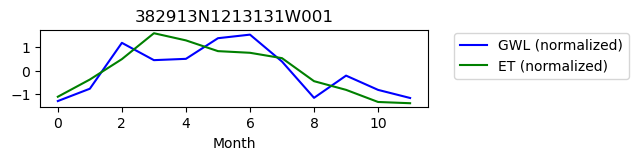

-------------------------
383264N1213191W001
ET GWL CORRELATION = 0.3802363654143331
ET GWL LAG = 2


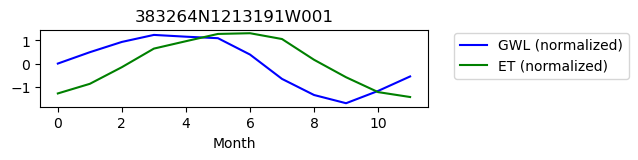

-------------------------
386016N1213761W001
ET GWL CORRELATION = 0.4701970041478893
ET GWL LAG = 2


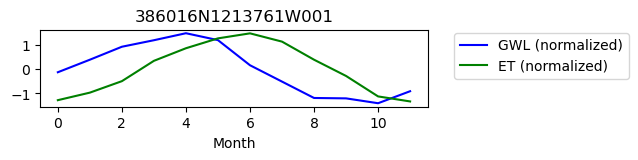

-------------------------
384121N1212102W001
ET GWL CORRELATION = 0.3672651700360673
ET GWL LAG = 2


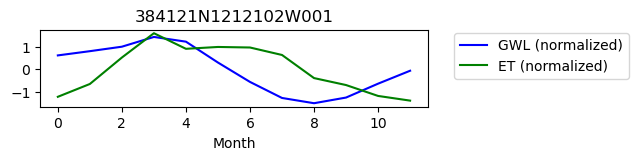

In [34]:
import numpy as np

# initialize an empty list to store results for later
analysis_results_list = []

# Loop through our sites
for site_id in site_id_list:

    # Get the GWL data 
    df_site_gwl = df_gwl_standard[df_gwl_standard['SITE_CODE'] == site_id][['wse_standard']]
    
    # Get the ET data 
    df_site_et = pd.DataFrame(et_results_df[site_id])
    df_site_et.columns = ["et"]
    df_site_et.index = pd.to_datetime(df_site_et.index)

    # Join the dataframes via the outer join to preserve the index, and drop areas with no data
    df_site = pd.DataFrame(df_site_et.dropna()).join(df_site_gwl.dropna(), how="outer")
    correlation = df_site.dropna().corr()["wse_standard"].iloc[0]

    # Extract the month from the 'date' column
    df_site["month"] = df_site.index.month

    # Calculate the mean value for each month
    df_gwl_monthly = df_site.groupby("month")["wse_standard"].mean()
    df_et_monthly = df_site.groupby("month")["et"].mean()

    # # Cross correlation (ORDER MATTERS!)
    b = df_gwl_monthly.values
    a = df_et_monthly.values

    # Normalize by mean and standard deviation
    a = (a - np.mean(a)) / (np.std(a))
    b = (b - np.mean(b)) / (np.std(b))

    cross_corr = np.correlate(a, b, "full")
    lags = np.arange(-len(a) + 1, len(b))

    max_lag_index = np.argmax(cross_corr)
    optimal_lag = lags[max_lag_index]

    print("-----" * 5)
    print(site_id)
    print("ET GWL CORRELATION = {}".format(correlation))
    print("ET GWL LAG = {}".format(optimal_lag))

    fig, ax = plt.subplots(figsize = (5,1))
    ax.plot(b, color = 'blue', label = 'GWL (normalized)');
    ax.plot(a, color = 'green', label = 'ET (normalized)'); 
    ax.legend(bbox_to_anchor=(1.05,1.05))
    ax.set_title(site_id)
    ax.set_xlabel("Month")
    plt.show()

    # Create a dataframe to store results
    rdf = pd.DataFrame([correlation, optimal_lag]).T
    rdf.columns = ["correlation", "lag"]
    rdf.index = [site_id]

    analysis_results_list.append(rdf)

### Postprocessing and visualization

In [35]:
# Concatenate results
analysis_results_df = pd.concat(analysis_results_list)

In [36]:
# Merge with lat/lon info
df_results = pd.merge(et_site_df, analysis_results_df, left_on="SITE_CODE", right_index=True)

In [37]:
# Plot as geopandas gdf

import geopandas as gpd

gdf_results = gpd.GeoDataFrame(
    df_results,
    geometry=gpd.points_from_xy(df_results["LONGITUDE"], df_results["LATITUDE"]),
    crs="EPSG:4326",  # Set the coordinate reference system (CRS)
)

<Axes: >

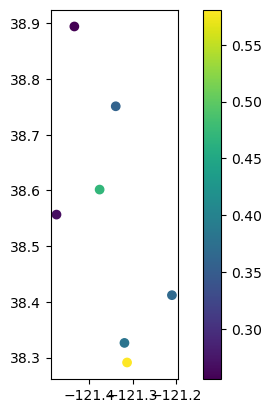

In [38]:
# Plot well locations colored by correlation

gdf_results.plot(column="correlation", legend=True)

<Axes: >

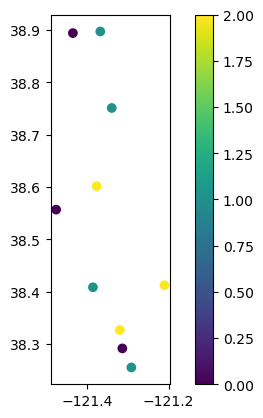

In [39]:
# Plot well locations colored by lag period

gdf_results.plot(column="lag", legend=True)

### Discussion of Analysis: 

We just conducted a crude analysis of the temporal dynamics between groundwater levels and evapotranspiration. 

With python data science and geospatial tools, we completed the following processing steps:

1. Read .csv data describing groundwater station locations (stations.csv)
2. Selected a number of stations from the larger dataset based on a list of station_ids
3. Joined the station data to groundwater level data based on a column value
4. Used the location information contained in the stations.csv to determine the lat/lon of each station
5. For each groundwater monitoring location:
    * Determined lat/lon coordinates
    * Queried the collocated ET data
    * Organized ET and GWL time series data as dataframes
    * Ensured that time windows of data overlap
6. Analyze the relationship between peak ET and peak GWL
    * Simple linear regression
    * Calculated monthly means
    * Cross correlation and lag periods on monthly means
7. Plotted and wrote our results to files

This procedure is similar to an analysis described in chapter 4 of [my phd thesis](https://stacks.stanford.edu/file/druid:vd768dm1610/Ahamed_Thesis_FMT_FIN-augmented.pdf).

### Spatial interpolation:

We successfully joined our correlations and lag periods back to the geospatial information in the `stations.csv` data, and plotted our results using `geopandas`. What if we wanted to interpolate those results to create a smooth surface? 

We can leverage the `scipy` function called `interpolate.griddata` to accomplish this. 

In [40]:
# Make arrays out of the points and values we want to interpolated
points = np.array(list(zip(gdf_results.geometry.x, gdf_results.geometry.y)))

# Let's select the 'lags'
values = gdf_results['lag'].values 

In [41]:
# Get the min and max lat / lon coordinates 
x_min, x_max = gdf_results.geometry.x.min(), gdf_results.geometry.x.max()
y_min, y_max = gdf_results.geometry.y.min(), gdf_results.geometry.y.max()

# Define grid resolution (adjust as needed)
x_res = 100
y_res = 100

# Create grid coordinates
xi, yi = np.meshgrid(np.linspace(x_min, x_max, x_res), 
                     np.linspace(y_min, y_max, y_res))

In [42]:
# Choose an interpolation method: 'linear', 'cubic', or 'nearest'
from scipy.interpolate import griddata

method = 'linear'  
zi = griddata(points, values, (xi, yi), method=method)

In [43]:
# We will create a new geodata frame of polygons to store our interpolated results 
from shapely.geometry import Polygon

# Flatten the grid and create a DataFrame
df = pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'value': zi.flatten()})
df = df.dropna(subset=['value']) # Remove NaN values

#Create polygons for each grid cell
cell_size_x = (x_max - x_min) / x_res / 0.9
cell_size_y = (y_max - y_min) / y_res / 0.9
df['geometry'] = df.apply(lambda row: Polygon([(row['x'], row['y']), 
                                              (row['x'] + cell_size_x, row['y']),
                                              (row['x'] + cell_size_x, row['y'] + cell_size_y),
                                              (row['x'], row['y'] + cell_size_y)]), axis=1)

# Create GeoDataFrame
interpolated_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=gdf_results.crs)

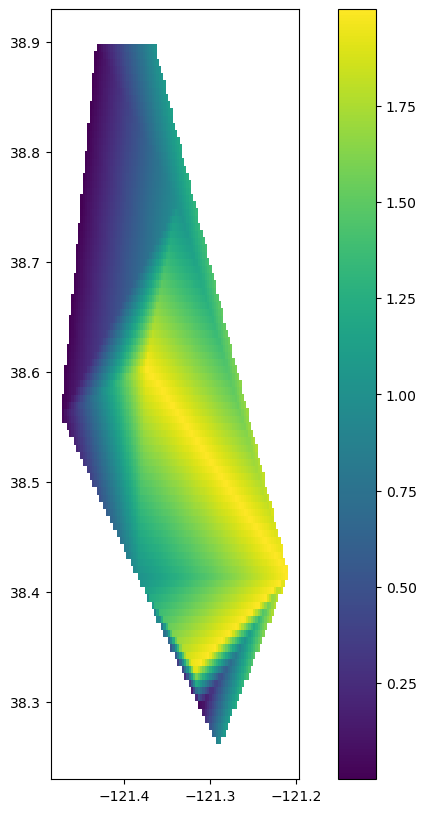

In [44]:
# Visualize

fig, ax = plt.subplots(figsize = (10,10))
interpolated_gdf.plot(column='value', ax=ax, legend=True)
plt.show()